In [248]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import datetime
import seaborn as sns
from scipy import stats
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes

**Newlyn**

Newlyn has tidal gauge data for the period 1915-2018, the longest functioning tide gauge in the UK.

In [2]:
file1 = "C:\\Users\\u2094706\\Downloads\\RN-7283_1638963930852\\Newlyn_19150101_19831231.txt"
file2 = "C:\\Users\\u2094706\\Downloads\\RN-7283_1638963930852\\Newlyn_19840101_20180430.txt"

In [3]:
dates=[]
values=[]

In [4]:
with open(file1,"r") as f:
    for line in f.readlines()[11:]:
        val = line.split()[-1].replace("N","")
        val = val.replace("M","")
        if val != "-99.0000":
            dates.append(line.split()[1])
            values.append(float(val))
with open(file2,"r") as f:
    for line in f.readlines()[11:]:
        val = line.split()[-1].replace("N","")
        val = val.replace("M","")
        val = val.replace("T","")
        if val != "-99.0000":
            dates.append(line.split()[1])
            values.append(float(val))

In [5]:
df = pd.DataFrame(columns=['date','value'],index=[i for i in range(len(dates))])
df['date'] = dates
df['value'] = values

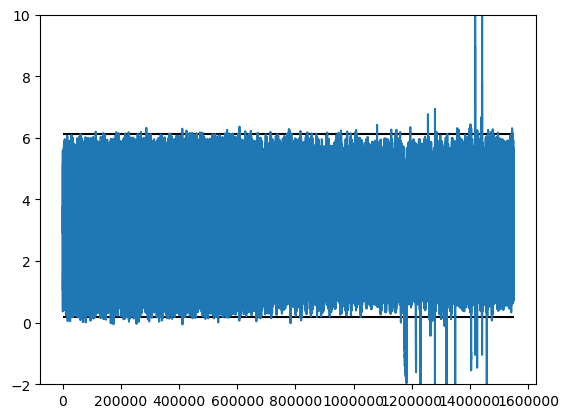

In [6]:
plt.plot(df['value'].values)
plt.hlines(6.13,xmin=0,xmax=len(df))
plt.hlines(0.18,xmin=0,xmax=len(df))
plt.ylim(-2,10)
plt.show()

**Filter dataframe** 

We know that lowest astronomical tide is listed as 0.18 and we know the highest recording was approx 7.84 in Mar'15
Filter out values below 0.1 and above 8

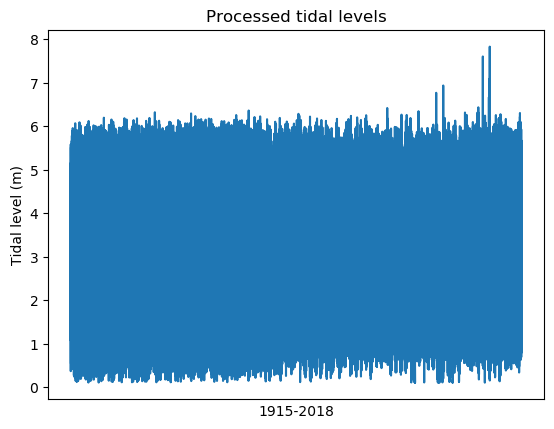

In [8]:
filtered = df[(df['value']>0.1)&(df['value']<8)]
plt.plot(filtered['value'].values)
plt.title("Processed tidal levels")
plt.ylabel("Tidal level (m)")
plt.xlabel("1915-2018")
plt.xticks([])
plt.show()

Some recordings are made hourly and some every 15-minutes. We aggregate data into a dataset of daily maxima. 

In [10]:
dates = filtered['date'].values
unique_dates = sorted([i for i in set(dates)])

f_df = pd.DataFrame(index=unique_dates,columns=['value'])
for i in unique_dates:
    dt = filtered[filtered['date']==i]
    if len(dt)>=24:
        f_df.loc[i,'value'] = np.max(dt['value'])
f_df.dropna(inplace=True)

Observe some more outliers so we filter those out. 

In [16]:
f_df = f_df[f_df['value']>3]

Save dataset.

In [17]:
f_df.to_csv("Newlyn_daily_max_1915_2018.csv")

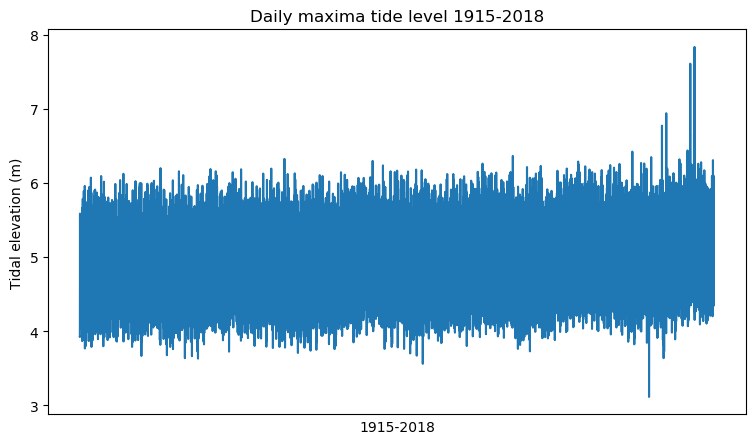

In [272]:
plt.figure(figsize=(9,5))
plt.plot(f_df['value'].values)
plt.title("Daily maxima tide level 1915-2018")
plt.ylabel("Tidal elevation (m)")
plt.xlabel("1915-2018")
plt.xticks([])
plt.show()

**Extreme values and how return periods change over time**

Defining points at every 1/5th of the data we construct and fit a GEV distribution from the data, at each time step i the data being used containing section i, i-1,...,0 such that the final GEV distribution is constructed on the full dataset we can observe how these distributions change over time with new data. 

For each distribution we estimate the return period of a tidal elevation greater than or equal to 7m. 

0.0
0.04
0.08
0.15
1.12


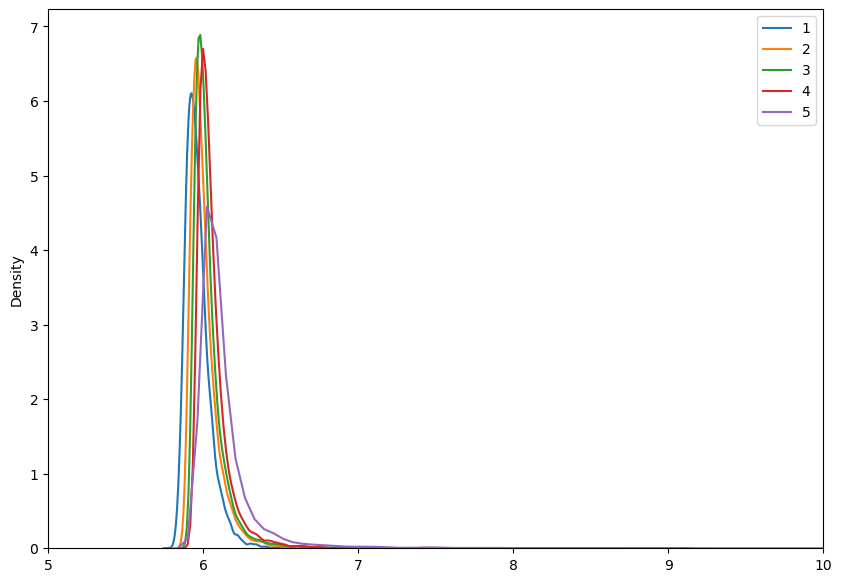

In [270]:
intervals = [i for i in range(0,len(f_df),int(len(f_df)/5))]
date_index = [datetime.datetime.strptime(i,'%Y/%m/%d') for i in f_df.index]

plt.figure(figsize=(10,7))
for i in range(1,len(intervals)):
    data = f_df['value'].values[:intervals[i]].astype("float")
    threshold = np.quantile(data,0.99)
    series = pd.Series(data=data,index=date_index[:intervals[i]])
    peaks = get_extremes(series,"POT",threshold=threshold)
    fit = stats.genextreme.fit(peaks)
    sample = stats.genextreme.rvs(fit[0],fit[1],fit[2],10000)
    print(100*len(sample[sample>=7])/len(sample))
    sns.kdeplot(sample)
plt.xlim(5,10)
plt.legend([str(i) for i in range(1,len(intervals))])
plt.show()

The values listed above show that under the first GEV distribution fitted to roughly the first 20-years of data, a 7m tidal elevation value appears completely improbable. 

With the final distribution we would expect such an elevation would approximately correspond to a 100-year return period.

We observe that the return period for such an event is decreasing as we introduce more data, yet the data from the latest 20-years is when we see this event become a lot more probable. 

Changing probabilties over time suggest that this method of stationary GEV distribution-based estimation of return periods is unlikely to be robust for future predictions. Currently, we see a 7m tidal elevation having a return period of 100-years but with another 10 or 15 years of data this could become a one in 50-years event, or even more frequent.

It's imperative we explore alternatives for estimation of return periods and extreme values.